In [1]:
import seaborn as sns; sns.set()

In [2]:
%matplotlib inline

In [3]:
import pickle
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [22]:
import numpy as np

# Sanity Checks
import scipy.optimize as opt
def get_fopt():
    '''After running the experiments and only saving the episode rewards, i realized
    that i could not recover the exact timesteps elapsed as each episode could consist
    of a varying number of timesteps. I created this function
    based on a single run of the vanilla dqn where i recorded timesteps
    and episodes, and attempted to fit a transformer from episodes to timesteps
    that i will use for all my results. All of this is because i dont want to pay for
    additional GPU compute. The form of the function assumes that timesteps/episodes is
    sigmoid wrt episodes.'''
    with open('p1q1.log.txt', 'r') as open_file:
        contents = open_file.readlines()

    episode_lines = filter(lambda line: line.startswith('episodes '), contents)
    episodes = list(map(lambda line: int(line.strip().replace('episodes ', '')), episode_lines))


    timestep_lines = filter(lambda line: line.startswith('Timestep '), contents)
    timesteps = list(map(lambda line: int(line.strip().replace('Timestep ', '')), timestep_lines))
    
    def f(x, a, b, c, d):
        return x*(a / (1. + np.exp(-c * (x - d))) + b)
    
    x = episodes
    y = timesteps
    p0 = (1000, 900, .02, 400)
    popt, _ = opt.curve_fit(f, x, y, p0=p0)
    fopt = lambda x: f(x, *popt)
    return fopt

fopt = get_fopt()
def moving_agg(series, window = 5, fnc=np.mean, window_placement='midpoint'):
    assert window_placement in ['midpoint', 'leading', 'trailing']
    if window_placement == 'midpoint':
        window_fnc = lambda i: (max(i-window//2, 0), i+window//2)
    elif window_placement == 'leading':
        window_fnc = lambda i: (max(i - window, 0), i + 1)
    else:
        window_fnc = lambda i: (i, window + i)
    for i in range(len(series)):
        start, end = window_fnc(i)
        agg = fnc(series[start:end])
        yield agg

def mean_and_best_100_df(results, name='vanilla'):
    mean_100 = list(moving_agg(results, window=100, fnc=np.mean, window_placement='leading'))
    best_mean_100 = list(moving_agg(mean_100, window=len(mean_100), fnc=np.max, window_placement='leading'))
    i = np.arange(len(mean_100)) + 1
    t = fopt(i)
    data = pd.DataFrame({
        'index': i,
        'timestep': t,
        'reward': mean_100,
        'name': name,
        'type': 'mean'
    })
    data_best = pd.DataFrame({
        'index': i,
        'timestep': t,
        'reward': best_mean_100,
        'name': name,
        'type': 'best'
    })
    data = pd.concat([data, data_best], axis=0)
    return data

In [23]:
with open('basicq.pkl', 'rb') as open_file:
    results = pickle.load(open_file)

In [24]:
data = mean_and_best_100_df(results, 'vanilla')

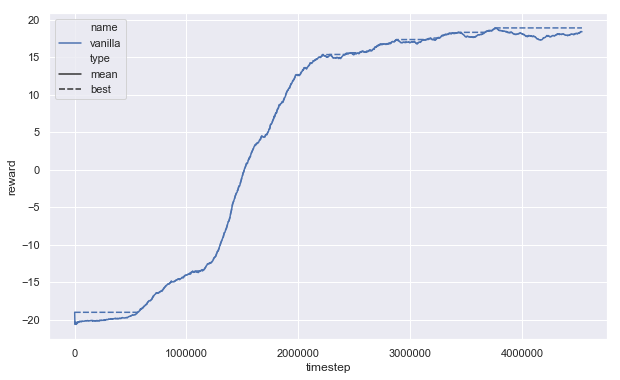

In [25]:
plt.figure(figsize=(10,6))
sns.lineplot(data=data, x='timestep', y='reward', hue='name', style='type')
plt.savefig('p1q1.png')

In [26]:
with open('doubleq.pkl', 'rb') as open_file:
    dqn_results = pickle.load(open_file)
    

In [27]:
dqn_data = mean_and_best_100_df(dqn_results, 'double q')
data = pd.concat([data, dqn_data], axis=0)

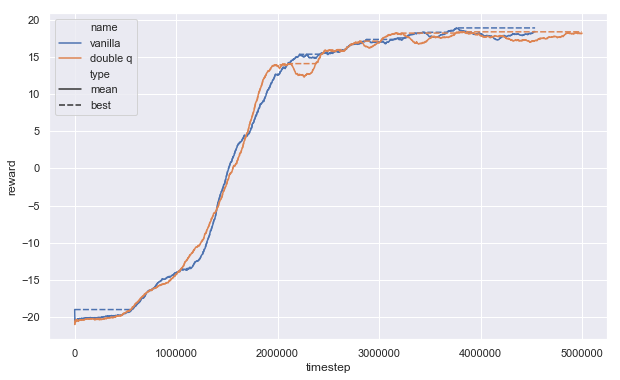

In [28]:
plt.figure(figsize=(10,6))
sns.lineplot(data=data.query('timestep < 5e6'), x='timestep', y='reward', hue='name', style='type')
plt.savefig('p1q2.png')

In [29]:
with open('doubleq_freq5000.pkl', 'rb') as open_file:
    results_5k = mean_and_best_100_df(pickle.load(open_file), '5k')

In [30]:
with open('doubleq_freq2500.pkl', 'rb') as open_file:
    results_2k = mean_and_best_100_df(pickle.load(open_file), '2.5k')

In [31]:
with open('doubleq_freq15000.pkl', 'rb') as open_file:
    results_15k = mean_and_best_100_df(pickle.load(open_file), '15k')

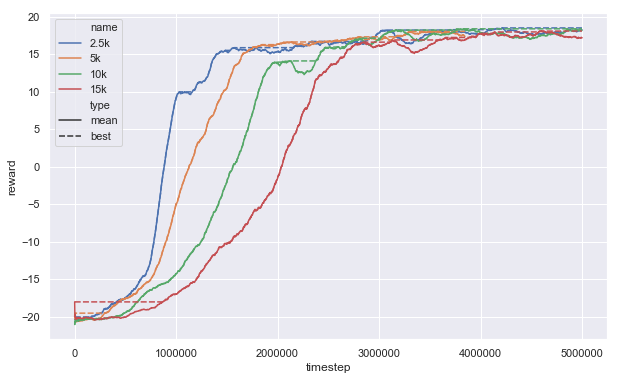

In [32]:
results_10k = dqn_data.copy()
results_10k['name'] = '10k'
data = pd.concat([results_2k, results_5k, results_10k, results_15k], axis=0)

plt.figure(figsize=(10,6))
sns.lineplot(data=data.query('timestep < 5e6'), x='timestep', y='reward', hue='name', style='type')
plt.savefig('p1q3.png')